# Basic Seurat analysis and correlation-based annotation

#### Demonstrated using toy data. The toy data was preprocessed to generate gene-by-cell matrices using scKB.

#### For the detail of scKB and access to toy data and supplementary data, please visit https://github.com/Hsu-Che-Wei/scKB.

#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the files, which are aviable on Github (github.com/Hsu-Che-Wei/COPILOT):

    Protoplasting_DEgene_FC2_list.txt (from Denyer, et al. 2019)
    color_scheme_at.RData (required if one choose to perform correlation-based annotation)
    Root_bulk_arabidopsis_curated.RD (required if one choose to perform correlation-based annotation)

In [1]:
rm(list=ls())
# Set the working directory to where the folder named after the sample is located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [2]:
# Load libraries
suppressMessages(library(Matrix))
suppressMessages(library(DropletUtils))
suppressMessages(library(ggplot2))
suppressMessages(library(scales))
suppressMessages(library(Seurat))
suppressMessages(library(tidyverse))

In [3]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/seu314/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] forcats_0.5.0               stringr_1.4.0              
 [3] dplyr_1.0.0                 purrr_0.3.4                
 [5] readr_1.3.1                 tidyr_1.1.0                
 [7] tibble_3.0.1                tidyverse_1.3.0            
 [9] Seurat_3.1.5        

## 1. Preparation

In [4]:
sample.name <- "col0_toy"

In [5]:
# Read in the quality-filtered spliced and unspliced counts matrices
spliced <- readMM(paste0('./', sample.name, '/spliced_counts_filtered/matrix.mtx')) # load raw mtx
genes <- read.csv(paste0('./', sample.name, '/spliced_counts_filtered/genes.tsv'), sep = '\t', header = F) # load genes
rownames(spliced) <- genes[,1] # attach gene_ids
colnames(spliced) <- read.csv(paste0('./', sample.name, '/spliced_counts_filtered/barcodes.tsv'), sep = '\t', header = F)[,1] # attach barcodes
unspliced <- readMM(paste0('./', sample.name, '/unspliced_counts_filtered/matrix.mtx')) # load raw mtx
genes <- read.csv(paste0('./', sample.name, '/unspliced_counts_filtered/genes.tsv'), sep = '\t', header = F) # load genes
rownames(unspliced) <- genes[,1] # attach gene_ids
colnames(unspliced) <- read.csv(paste0('./', sample.name, '/unspliced_counts_filtered/barcodes.tsv'), sep = '\t', header = F)[,1] # attach barcodes

In [6]:
# Combined spliced and unspliced transcripts
combined <- spliced + unspliced

In [7]:
# Create Seurat Object
seu <- suppressWarnings(CreateSeuratObject(counts = combined, assay = "RNA", project = sample.name))
seu[["spliced_RNA"]] <- CreateAssayObject(spliced)
seu[["unspliced_RNA"]] <- CreateAssayObject(unspliced)
DefaultAssay(seu) <- "RNA"

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from spliced_rna_ to splicedrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from unspliced_rna_ to unsplicedrna_”


In [8]:
# SCTransform normalization using "all the genes/features", notice that we do not perform selection of highly variable genes 
suppressWarnings(
seu <- SCTransform(seu, variable.features.n = nrow(seu), assay = "RNA", new.assay.name = "SCT", verbose = FALSE)
)

In [2]:
# Load unwanted genes, which are genes being induced during protoplasting in our case
pp.genes <- as.character(read.table("./supp_data/Protoplasting_DEgene_FC2_list.txt", header=F)$V1)

In [10]:
# Prepare list of genes to be use in PCA, UMAP ... etc. Here we use "all the genes/features" except for mitochondrial genes, chloroplast genes and genes involved in protoplasting 
use.genes <- rownames(seu)[-c(grep(paste("ATMG", collapse = "|"),rownames(seu)),grep(paste("ATCG", collapse = "|"),rownames(seu)),sort(match(pp.genes, rownames(seu))))]

## 2. Correlation-based annotation

In [11]:
# Load reference expression profiles
load(file="./supp_data/Root_bulk_arabidopsis_curated.RD")

In [12]:
# Reference expression profiles for time
time[1:10,]

,Elong,Mat,Mer
,<dbl>,<dbl>,<dbl>
AT1G01120,7.656821,11.103403,3.006378
AT1G02900,9.926009,12.979756,3.492276
AT1G03870,12.534193,9.386435,9.177053
AT1G03920,7.855225,10.066055,4.393562
AT1G04040,10.863673,7.073946,6.398402
AT1G04250,12.082874,11.362286,7.606156
AT1G04870,8.407653,6.742451,11.239171
AT1G05320,10.064879,11.176356,6.484858
AT1G05850,12.380340,13.428263,9.722099


In [13]:
# Reference expression profiles for cell type
celltype[1:10,]

,APL,CO2,COBL9,COR,E30,GL2,PET111,S17,S18,S32,S4,SCR,WER,WOX5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AT1G02640,9.032188,5.741855,4.255736,4.060487,5.817228,3.577914,6.573193,6.269740,15.107434,9.277301,9.746276,6.863610,3.727183,4.634061
AT1G03920,6.639946,5.280079,7.477305,6.181501,14.322581,6.669014,6.310183,7.703052,12.296365,5.404032,6.280222,11.449384,6.270373,6.646217
AT1G04040,7.769144,6.459907,12.179834,10.146437,7.534954,10.028690,7.898720,6.295741,8.079254,6.442428,5.991661,9.519618,9.457058,6.742527
AT1G04250,9.768452,9.046264,11.765231,12.195614,8.734623,10.564701,11.980258,11.092788,8.489452,8.265820,6.910604,10.164387,10.420877,8.368874
AT1G04610,6.260897,7.647246,9.351918,6.773349,5.707790,8.549714,11.238024,5.163161,5.833860,7.350397,5.670868,7.745656,8.637965,11.781049
AT1G05260,8.436722,5.144425,5.301265,6.994666,12.445246,5.009265,5.732056,8.289503,8.236419,6.938349,4.781552,13.915111,4.001330,9.305960
AT1G07640,12.530044,5.249962,2.223863,3.854710,5.691303,2.058811,4.105596,10.893532,5.022887,11.051942,3.161890,3.815076,1.689251,4.341605
AT1G08930,6.483707,8.682147,9.647659,10.365510,12.082584,9.348471,8.617589,6.869924,6.069459,4.548753,4.815387,9.126445,8.369881,7.380026
AT1G09090,7.207368,8.803633,4.944273,11.258744,13.315021,4.913806,4.275706,7.088283,6.889441,5.884083,3.872831,11.940631,3.799964,6.902103


In [14]:
# Extract matrix of SCTransformed expression value 
rc <- as.matrix(seu@assays$SCT@data)

In [15]:
# Merge the reference expression profile with the normalized expression matrix of our sample  

merge.rownames <- function (x,y){
  dat <- merge(x = x, y = y, by = "row.names")
  rownames(dat) <- dat$Row.names
  dat <- dat[,-1]
  return(dat)
}

time <- Reduce(merge.rownames, list(time,rc))
celltype <- Reduce(merge.rownames, list(celltype,rc))

In [16]:
# Prepare customized label name (optional)
time_label=c("Elongation", "Maturation", "Meristem")
celltype_label=c("phloem & companion cells", "developing cortex", "hair cells", "matured cortex",
                   "matured endodermis", "non-hair cells", "columella", "phloem pole pericycle",
                   "matured xylem pole", "protophloem & metaphloem","developing xylem", "endodermis & QC cells", "LRC & non-hair cells","QC cells")

In [17]:
# Calculating the correlation coefficient of each cell to each reference expression profile and annotate the cell as the label that it has the highest correlation coefficient with.  
time_stat <- suppressWarnings(sapply(4:ncol(time), function(i) sapply(1:3, function(j) cor.test(time[,i],time[,j],method = "pearson")[c(3,4)])))
time_cor <- time_stat[seq(2,nrow(time_stat),2),]
time_pvalue <- time_stat[seq(1,nrow(time_stat)-1,2),]
time_max <- sapply(1:(ncol(time)-3), function(i) max(as.numeric(time_cor[,i])))
time_ident <- sapply(1:(ncol(time)-3), function(i) time_label[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])
time_maxp <- sapply(1:(ncol(time)-3), function(i) as.numeric(time_pvalue[,i])[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])
names(time_max) <- time_ident
                    
celltype_stat <- suppressWarnings(sapply(15:ncol(celltype), function(i) sapply(1:14, function(j) cor.test(celltype[,i],celltype[,j],method = "pearson")[c(3,4)])))
celltype_cor <- celltype_stat[seq(2,nrow(celltype_stat),2),]
celltype_pvalue <- celltype_stat[seq(1,nrow(celltype_stat)-1,2),]
celltype_max <- sapply(1:(ncol(celltype)-14), function(i) max(as.numeric(celltype_cor[,i])))
celltype_ident <- sapply(1:(ncol(celltype)-14), function(i) celltype_label[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])
celltype_maxp <- sapply(1:(ncol(celltype)-14), function(i) as.numeric(celltype_pvalue[,i])[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])
names(celltype_max) <- celltype_ident

In [18]:
# Store the annotation, correlation coefficient and the p-value in Seurat object
seu@meta.data$celltype.ID.P <- as.character(celltype_ident)
seu@meta.data$timezone.ID.P <- as.character(time_ident)
seu@meta.data$celltype.cor.P <- celltype_max
seu@meta.data$timezone.cor.P <- time_max
seu@meta.data$celltype.pvalue.P <- celltype_maxp
seu@meta.data$timezone.pvalue.P <- time_maxp

# In case there is cell with insufficient information for annotation, label them as "unknown"
seu@meta.data$celltype.ID.P[which(seu@meta.data$celltype.ID.P=='character(0)')]="unknown"
seu@meta.data$timezone.ID.P[which(seu@meta.data$timezone.ID.P=='character(0)')]="unknown"

## 3. Run PCA, UMAP and do clustering

In [19]:
# Run PCA
seu <- RunPCA(seu, verbose = FALSE, approx = FALSE, npcs = 50, features=use.genes)

In [20]:
# Run UMAP
suppressMessages(suppressWarnings(
  seu <- RunUMAP(seu, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
))

In [21]:
# Find nearest neighbors
suppressMessages(suppressWarnings(
  seu <- FindNeighbors(seu, reduction = "pca",dims = 1:50)
))

In [22]:
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
suppressMessages(suppressWarnings(
  seu <- FindClusters(seu, resolution = 0.5, algorithm = 4)
))

## 4. Plotting

In [23]:
# Load the color scheme for time and cell type annotation
load("./supp_data/color_scheme_at.RData")
celltypepalette <- c(celltypepalette, "#eeeeee")
celltypeorder <- c(celltypeorder, "unknown")

In [24]:
# Make sure that the color match to the label it is supposed to color 
color <- celltypepalette[sort(match(unique(seu@meta.data$celltype.ID.P),celltypeorder))]

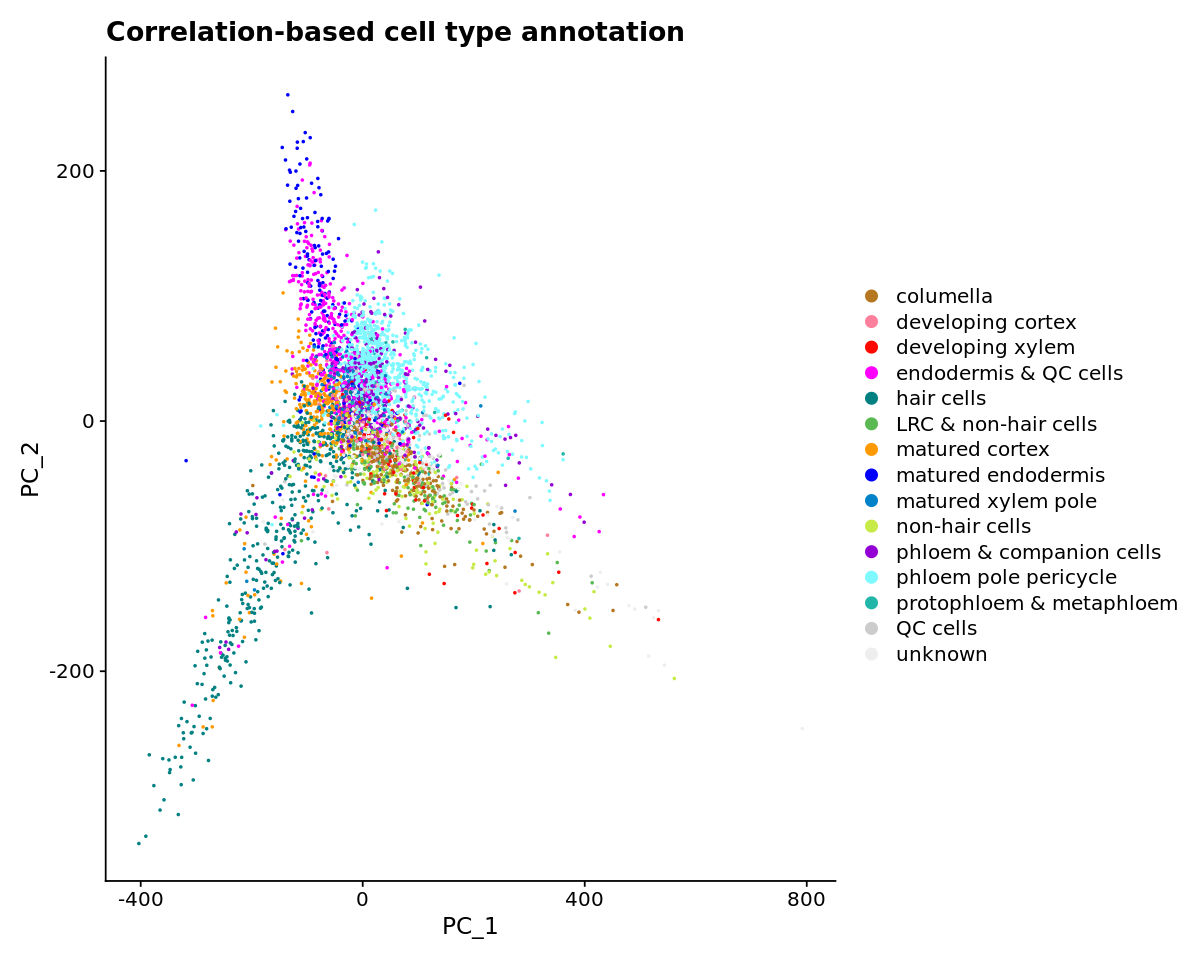

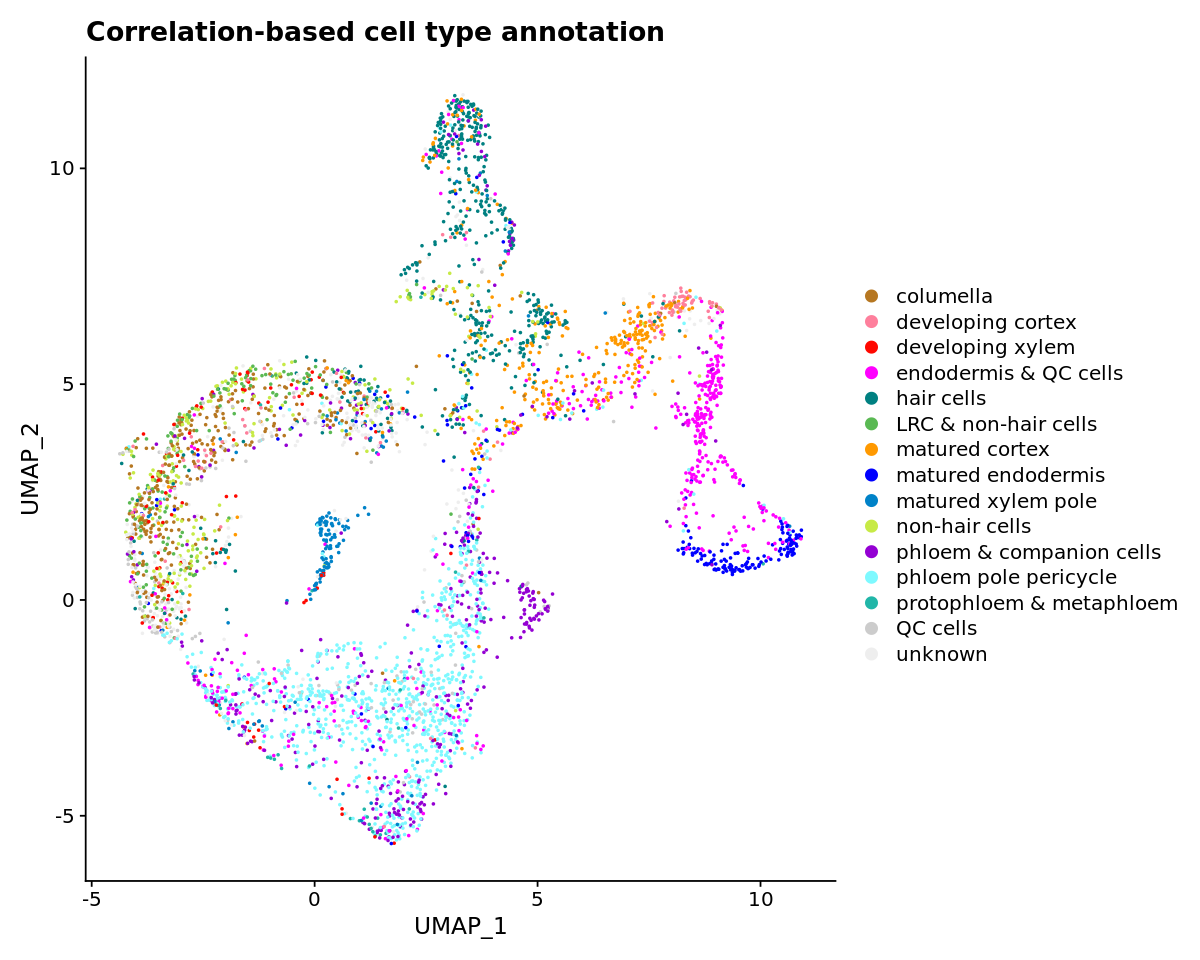

In [25]:
# Correlation-based celltype annotation
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(seu, reduction = "pca", group.by = "celltype.ID.P", cols = color)+ggtitle("Correlation-based cell type annotation")
DimPlot(seu, reduction = "umap", group.by = "celltype.ID.P", cols = color)+ggtitle("Correlation-based cell type annotation")

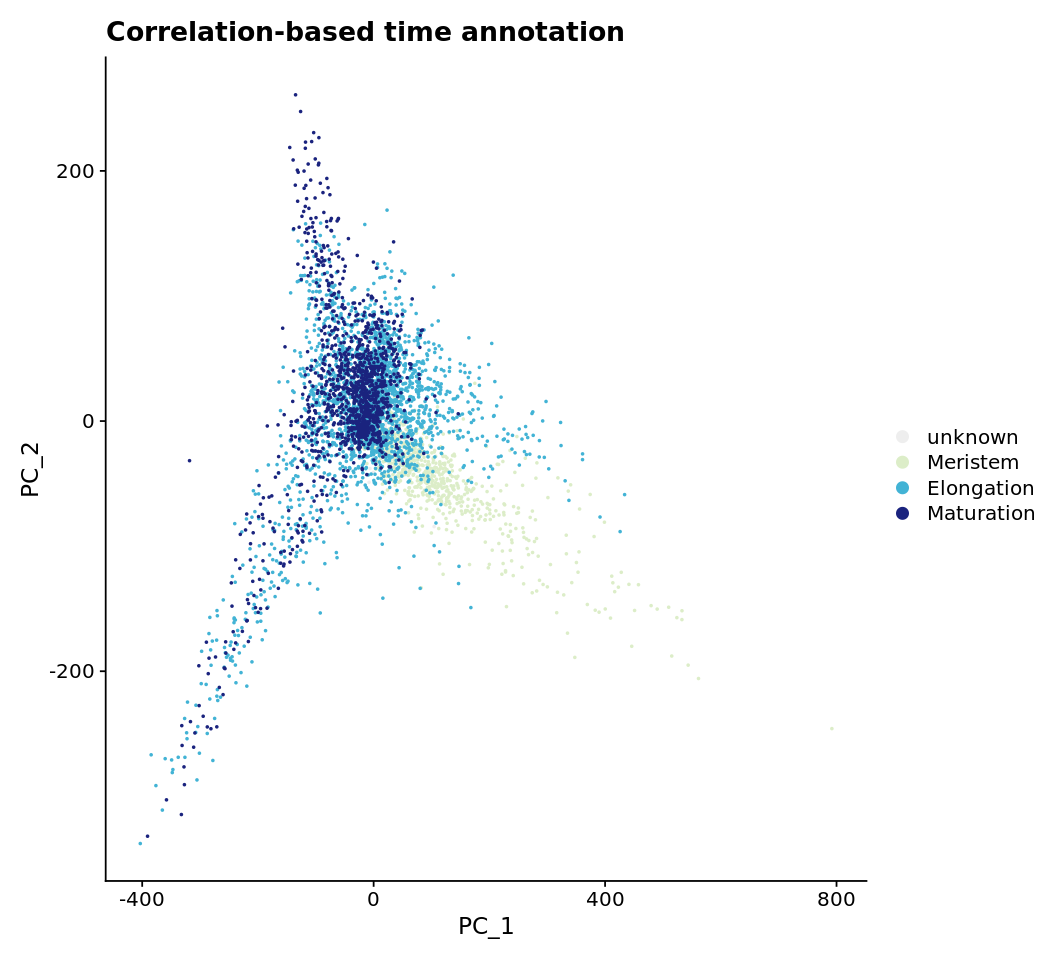

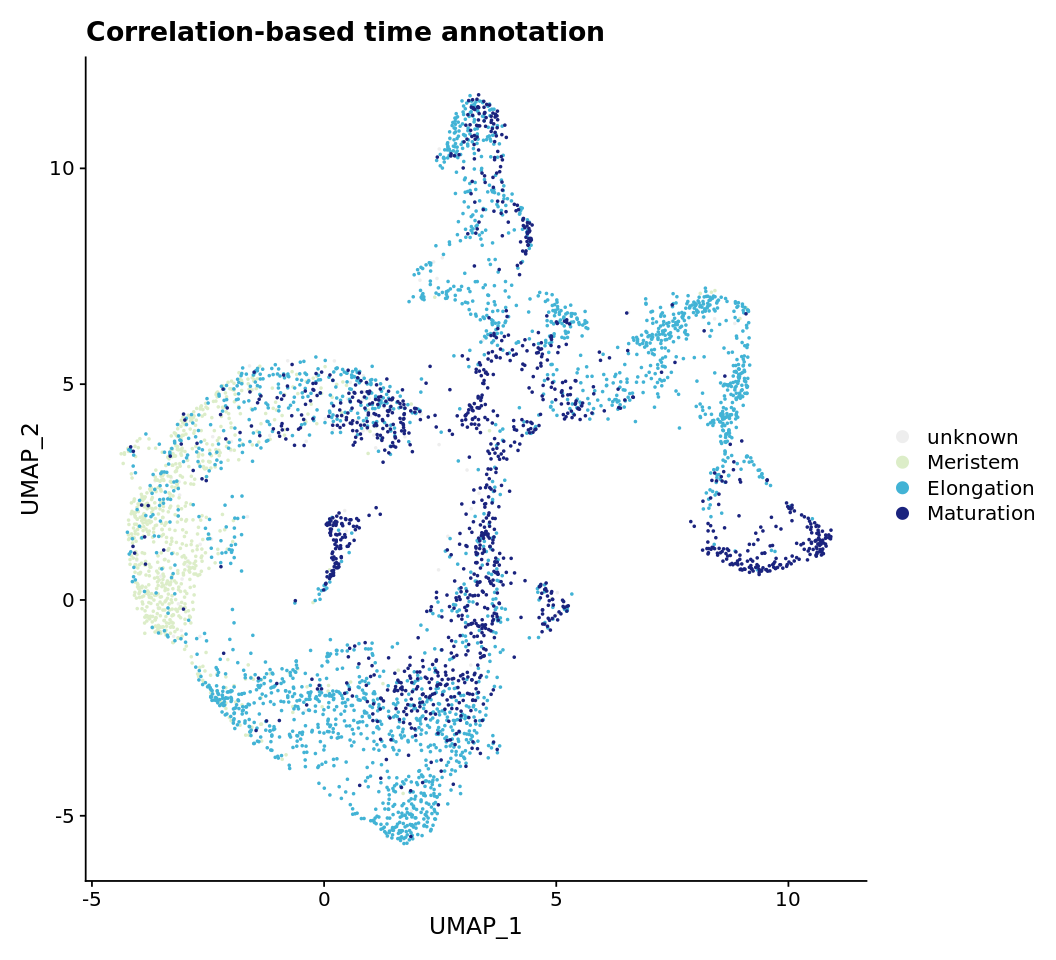

In [26]:
# Correlation-based time annotation
options(repr.plot.width=8.8, repr.plot.height=8)
DimPlot(seu, reduction = "pca", group.by = "timezone.ID.P", order = c("Maturation","Elongation","Meristem", "unknown"),cols = c("#eeeeee", "#DCEDC8", "#42B3D5", "#1A237E"))+ggtitle("Correlation-based time annotation")
DimPlot(seu, reduction = "umap", group.by = "timezone.ID.P", order = c("Maturation","Elongation","Meristem", "unknown"),cols = c("#eeeeee", "#DCEDC8", "#42B3D5", "#1A237E"))+ggtitle("Correlation-based time annotation")

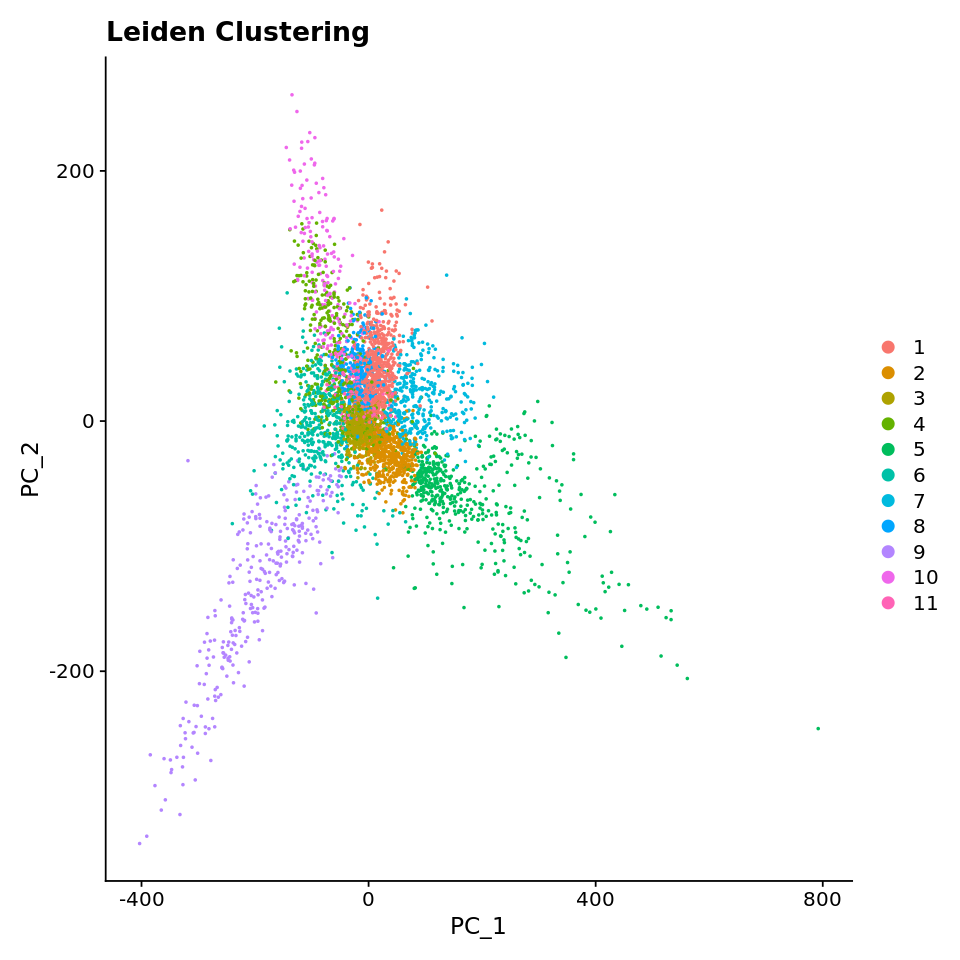

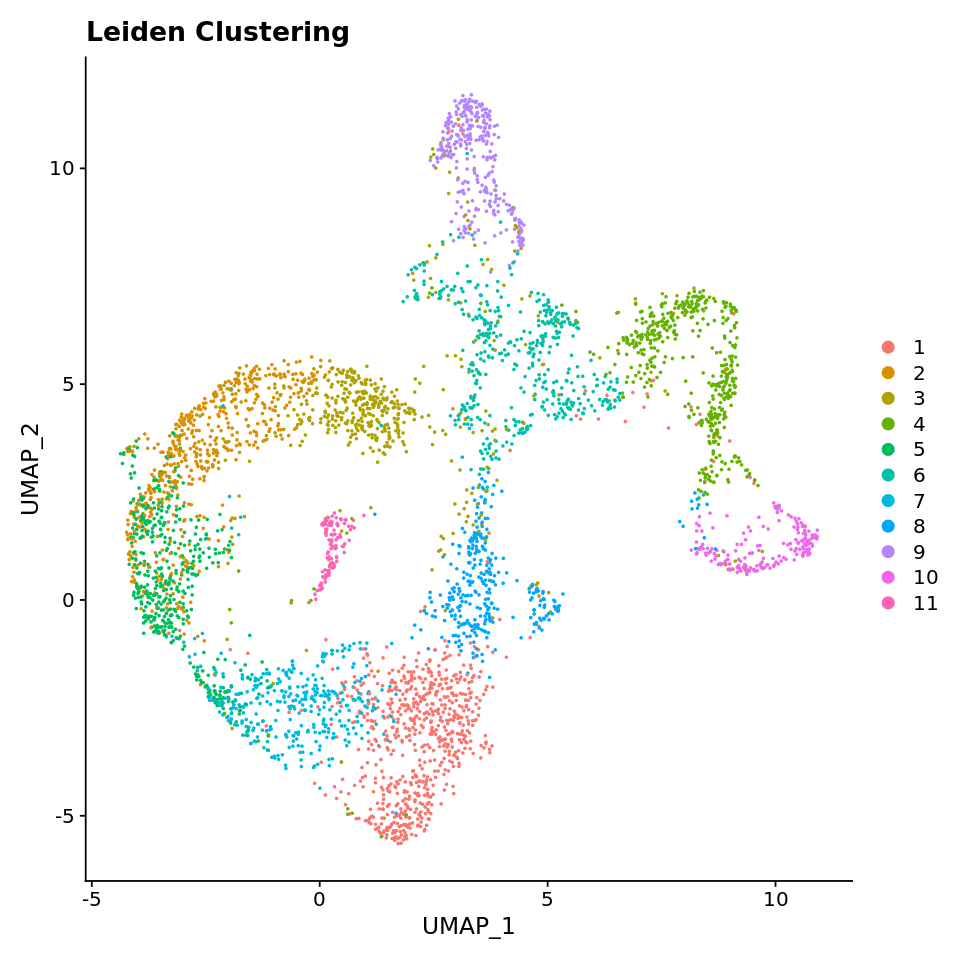

In [27]:
# Leiden Clustering 
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu, reduction = "pca")+ggtitle("Leiden Clustering")
DimPlot(seu, reduction = "umap")+ggtitle("Leiden Clustering")

In [28]:
# Save Seurat object
saveRDS(seu, file = paste0(paste0("./",sample.name,"/"),sample.name,"_COPILOT.rds"))